In [36]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder

In [37]:
df = pd.read_csv('train.csv')

/var/folders/tn/pky4_jf56t74wlclcq15d9sc0000gn/T/ipykernel_92171/2436019669.py:1: DtypeWarning: Columns (26) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('train.csv')


In [38]:
df.head()

,ID,Customer_ID,Month,Name,Age,SSN,Occupation,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,...,Credit_Mix,Outstanding_Debt,Credit_Utilization_Ratio,Credit_History_Age,Payment_of_Min_Amount,Total_EMI_per_month,Amount_invested_monthly,Payment_Behaviour,Monthly_Balance,Credit_Score
0,0x1602,CUS_0xd40,January,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,1824.843333,3,...,_,809.98,26.822620,22 Years and 1 Months,No,49.574949,80.41529543900253,High_spent_Small_value_payments,312.49408867943663,Good
1,0x1603,CUS_0xd40,February,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,NaN,3,...,Good,809.98,31.944960,NaN,No,49.574949,118.28022162236736,Low_spent_Large_value_payments,284.62916249607184,Good
2,0x1604,CUS_0xd40,March,Aaron Maashoh,-500,821-00-0265,Scientist,19114.12,NaN,3,...,Good,809.98,28.609352,22 Years and 3 Months,No,49.574949,81.699521264648,Low_spent_Medium_value_payments,331.2098628537912,Good
3,0x1605,CUS_0xd40,April,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,NaN,3,...,Good,809.98,31.377862,22 Years and 4 Months,No,49.574949,199.4580743910713,Low_spent_Small_value_payments,223.45130972736786,Good
4,0x1606,CUS_0xd40,May,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,1824.843333,3,...,Good,809.98,24.797347,22 Years and 5 Months,No,49.574949,41.420153086217326,High_spent_Medium_value_payments,341.48923103222177,Good


In [39]:
df["Payment_Behaviour"].unique()

array(['High_spent_Small_value_payments',
       'Low_spent_Large_value_payments',
       'Low_spent_Medium_value_payments',
       'Low_spent_Small_value_payments',
       'High_spent_Medium_value_payments', '!@9#%8',
       'High_spent_Large_value_payments'], dtype=object)

In [40]:
df["Credit_Score"].unique()

array(['Good', 'Standard', 'Poor'], dtype=object)

In [41]:
# Вычисляем процент клиентов с Poor для каждого значения Payment_Behaviour
poor_pct = df.groupby("Payment_Behaviour")["Credit_Score"].apply(lambda x: (x=="Poor").mean()*100).reset_index()

poor_pct.columns = ["Payment_Behaviour", "Percentage_Poor"]
print(poor_pct)


                  Payment_Behaviour  Percentage_Poor
0                            !@9#%8        29.276316
1   High_spent_Large_value_payments        21.711246
2  High_spent_Medium_value_payments        25.307868
3   High_spent_Small_value_payments        27.231041
4    Low_spent_Large_value_payments        28.115108
5   Low_spent_Medium_value_payments        30.380203
6    Low_spent_Small_value_payments        35.766080


In [42]:
df = df.drop(columns=['ID', 'Customer_ID', 'Name', 'SSN'])
df = df.dropna()

numeric_columns = ['Age', 'Annual_Income', 'Monthly_Inhand_Salary', 'Num_Bank_Accounts', 'Num_Credit_Card',
                   'Interest_Rate', 'Num_of_Loan', 'Delay_from_due_date', 'Num_of_Delayed_Payment', 
                   'Changed_Credit_Limit', 'Num_Credit_Inquiries', 'Credit_Utilization_Ratio', 
                   'Outstanding_Debt', 'Total_EMI_per_month', 'Amount_invested_monthly', 'Monthly_Balance']

for col in numeric_columns:
    df[col] = pd.to_numeric(df[col], errors='coerce')

le = LabelEncoder()

df['Credit_Score'] = le.fit_transform(df['Credit_Score'])
df = df.select_dtypes(include=[np.number])
df = df.dropna()

print(f"Осталось {len(df)} объектов в выборке.")

Осталось 44568 объектов в выборке.


In [44]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC

# Создаем датасет для модели, включающий числовые признаки и целевой признак "Credit_Score"
df_model = df.copy()
df_model["Credit_Score"] = df.loc[df.index, "Credit_Score"]

# Разделяем данные на признаки и целевую переменную
X = df_model.drop("Credit_Score", axis=1)
y = df_model["Credit_Score"]

# Разбиваем данные на обучающую и тестовую выборки с соотношением 80/20,
# со стратификацией по целевому признаку и random_state=1
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=1)

# Обучаем модель SVC с параметрами по умолчанию
model = SVC()
model.fit(X_train, y_train)

# Выводим опорные векторы
support_vectors = model.support_vectors_
num_support_vectors = support_vectors.shape[0]
num_support_vectors


31328

In [48]:
from sklearn.metrics import recall_score

kernels = ['linear', 'rbf', 'poly']
results = {}

for kernel in kernels:
    pipe = make_pipeline(StandardScaler(), SVC(kernel=kernel))
    pipe.fit(X_train_sample, y_train_sample)
    y_pred = pipe.predict(X_test_sample)
    recall_macro = recall_score(y_test_sample, y_pred, average='macro')
    results[kernel] = recall_macro

results_best = max(results, key=results.get)
results, results_best


({'linear': 0.42432167787990777,
  'rbf': 0.45804228798934093,
  'poly': 0.39674809427545615},
 'rbf')

Лучшее ядро: rbf
Лучшее значение C: 100


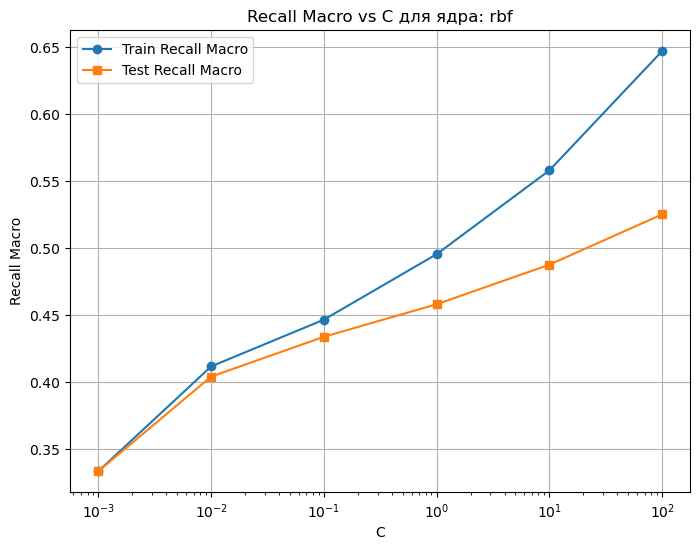

In [49]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import recall_score

# Повторно создаем уменьшённые выборки, если они не сохранены:
np.random.seed(1)
train_indices = np.random.choice(X_train.index, size=10000, replace=False)
X_train_sample = X_train.loc[train_indices]
y_train_sample = y_train.loc[train_indices]

np.random.seed(2)
test_indices = np.random.choice(X_test.index, size=2000, replace=False)
X_test_sample = X_test.loc[test_indices]
y_test_sample = y_test.loc[test_indices]

# Восстановим лучшее ядро из предыдущего задания:
kernels = ['linear', 'rbf', 'poly']
kernel_results = {}
for kernel in kernels:
    pipe = make_pipeline(StandardScaler(), SVC(kernel=kernel))
    pipe.fit(X_train_sample, y_train_sample)
    y_pred = pipe.predict(X_test_sample)
    kernel_results[kernel] = recall_score(y_test_sample, y_pred, average='macro')
best_kernel = max(kernel_results, key=kernel_results.get)
print("Лучшее ядро:", best_kernel)

# Подбираем параметр C:
c_values = [0.001, 0.01, 0.1, 1, 10, 100]
train_scores = []
test_scores = []

for c in c_values:
    pipe = make_pipeline(StandardScaler(), SVC(kernel=best_kernel, C=c))
    pipe.fit(X_train_sample, y_train_sample)
    y_train_pred = pipe.predict(X_train_sample)
    y_test_pred = pipe.predict(X_test_sample)
    train_scores.append(recall_score(y_train_sample, y_train_pred, average='macro'))
    test_scores.append(recall_score(y_test_sample, y_test_pred, average='macro'))

# Определяем значение C с максимальным macro recall на тестовой выборке
best_c = c_values[np.argmax(test_scores)]
print("Лучшее значение C:", best_c)

# Визуализация:
plt.figure(figsize=(8,6))
plt.plot(c_values, train_scores, marker='o', label='Train Recall Macro')
plt.plot(c_values, test_scores, marker='s', label='Test Recall Macro')
plt.xscale('log')
plt.xlabel('C')
plt.ylabel('Recall Macro')
plt.title('Recall Macro vs C для ядра: {}'.format(best_kernel))
plt.legend()
plt.grid(True)
plt.show()
